# Odor spectra in chemical space(s)

### Preperations

#### standard imports

In [1]:
import glob, csv, pickle, os, json, sys
import matplotlib, scipy
import copy

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, leaders, fcluster
from matplotlib import gridspec
from sklearn.manifold import MDS

#### custom imports

include those modules in your PYTHONPATH or directly in the folder of this notebook. Modules can be found at https://github.com/jansoe

In [3]:
from regnmf import ImageAnalysisComponents as ia
from bootstrap_prediction import bootstrap_predictor as bp
from bootstrap_prediction import datastructures as ds
# workaround because fspaces.pik (and multivarreg.pik below) was created before 
# refactoring datastructures and bootstrap_predictor into bootstrap_prediction
sys.modules['datastructures'] = ds
sys.modules['bootstrap_predictor'] = bp

#### notebook behavior

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 150

#### functions to process hierachichal clustering results (linkages)

In [27]:
def return_all_childs(mylinkage, parent):
    ''' recursive function returns all leaf node indexes below a parent node in mylinkage
    
        parent: node index
        mylinkage = scipy.cluster.hierarchy.linkage result
    '''    
    num_leaves = mylinkage.shape[0]+1
    parent = int(parent)
    if parent<num_leaves:
        return [int(parent)]
    else:
        leftchild, rightchild = mylinkage[parent-num_leaves][:2]
        return return_all_childs(mylinkage, parent=leftchild) + return_all_childs(mylinkage, parent=rightchild)

def return_all_links(mylinkage, parent):
    ''' recursive function returns all nodes below of parent node in mylinkage''' 
    num_leaves = mylinkage.shape[0]+1
    parent = int(parent)
    if parent<num_leaves:
        return [parent]
    else:
        leftchild, rightchild = mylinkage[parent-num_leaves][:2]
        return [parent] + return_all_links(mylinkage, parent=leftchild) + return_all_links(mylinkage, parent=rightchild)

def color_clusters(cluster, color_dict = None):
    ''' creates link-coloring function to color each cluster (given by parent node) '''
    cluster_colors = defaultdict(lambda: '0.5')
    for clust_ix, cluster_parent in enumerate(cluster):
        clust_color = color_dict[cluster_parent] if color_dict else plt.cm.prism(1.*clust_ix/len(cluster)) 
        clust_color = matplotlib.colors.rgb2hex(clust_color)
        colordict_update = {i: clust_color for i in return_all_links(link, cluster_parent+link.shape[0]+1)}
        cluster_colors.update(colordict_update)
    return lambda node: cluster_colors[node]

####  plotting parameter

In [36]:
fig_dim = (7.48,9.4)
global_fs= 7 

layout = {   'axes.labelsize': 7,
             'axes.linewidth': .5, 
             'xtick.major.size': 2,     # major tick size in points
             'xtick.minor.size': 1,     # minor tick size in points
             'xtick.labelsize': 7,       # fontsize of the tick labels
             'xtick.major.pad': 2,  
             
             'ytick.major.size': 2,      # major tick size in points
             'ytick.minor.size': 1,     # minor tick size in points
             'ytick.labelsize':7,       # fontsize of the tick labels
             'ytick.major.pad': 2,
             
             'mathtext.default' : 'regular',
             'legend.fontsize': 7,
             'figure.dpi':150
             }

for k, v in layout.items():
    matplotlib.rcParams[k] = v 

#### data locations

In [11]:
#datapath = '/media/jan/BackupWork/Documents/NewAnalysis'
toplevelpath = os.path.realpath(os.path.pardir)
datapath = os.path.join(toplevelpath, 'glomcentric_data_preprocessed')

factorization_path = os.path.join(datapath, 'MOBdecomposed')
bg_path = os.path.join(datapath, 'MOBconverted')
cas2name_file = os.path.join(datapath, 'DataDicts', 'Name2MomCas.tab')
cas2molid_file = os.path.join(datapath, 'ChemBase','odors_dez2013','cas2molid.csv')

#cluster_file = os.path.join(datapath, 'DataDicts', 'cluster_assignment.json')
#spec_savepath = os.path.join(datapath, 'DataDicts')
#vis_path = os.path.join(datapath, 'Vis')
#clustering_savepath = os.path.join(vis_path, 'Clustering')
#fingerprinted_specfile = os.path.join(datapath, 'DataDicts', 
#                                      'spectra_correlation_average_nnmf_150_sm2_convex_sp_ios_meas', 'ts')

## Set analysis parameter

#### Specify parameter

In [12]:
# specify filename speicification of data to use (with wildcard *)
method = 'nnmf_150_sm2_convex_sp*_ios_meas' #'sica_200_ios_meas'
# specify animals to include
animals =  ['111210sph', '111221sph','111222sph', '120107', '120119', '120121', '120125']
# select maximale trial2trial correlation distance (aka 1-correlation) of modes to be included
stimulusdrive = 0.4
# slecet minimal activation strength of modes to be included
min_activation = 0.2
# space in which chemical similarity shall be evaluated
fspace = 'edragon-eva5' # 'haddad' # 

### Load data

#### Function to load and preprocess all measurement data

Final measurement set will pruned to odors only present in all animals

In [13]:
def load_combined_series(allIDs, filemask, thres, min_strength, factorization_path):
    ''' function to load and preprocess timeseries of multiple animals '''
    
    allgood, turn = [], []
    for measID in allIDs:
        
        # load timeseries
        ts = ia.TimeSeries()
        filename = glob.glob(os.path.join(factorization_path, measID, filemask+'.npy'))
        assert len(filename)==1
        ts.load(filename[0].split('.')[0])
        ts.label_stimuli = [i.split('_')[0] for i in ts.label_stimuli]
        
        # if data from left bulb: turn
        if '_l_' in ts.name: 
            turn.append(measID)
            ts.base.set_series(ts.base.shaped2D()[:,::-1])
            
        ts.name = measID
        
        # calc odor spectrum of modes
        signal = ia.TrialMean()(ia.CutOut((2, 5))(ts))        
        # calc t2t correlation, exclude modes with t2t < thres
        mode_cor = ia.CalcStimulusDrive()(signal)
        signal = ia.SelectObjects()(signal, mode_cor._series.squeeze()<thres)
        
        # calc single odor response
        signal = ia.SingleSampleResponse()(signal)
        
        # selected only modes with maximal activation above min_strength
        strength = np.max(signal._series,0)
        signal = ia.SelectObjects()(signal, strength>min_strength)
        
        allgood.append(signal)
        
    allgood = ia.ObjectConcat(unequalsample=True)(allgood)
    return allgood, turn

#### Read in data

In [19]:
featurespaces = pickle.load(open(os.path.join(datapath, 'DataDicts','fspaces.pik')))

cas2molid = {l[0]:l[1] for l in csv.reader(open(cas2molid_file))}
#cas2name = {l[0]:l[1] for l in csv.reader(open(cas2name_file),  delimiter='\t')}
#molid2name = {v:cas2name[k] for k,v in cas2molid.items() if k in cas2name}

ts, turn = load_combined_series(animals, method, stimulusdrive, min_activation, factorization_path)

# load background images, turn if left bulb
bg_dict = {measID: plt.imread(os.path.join(bg_path, measID, 'bg.png')) for measID in animals}
for ani in turn:
    bg_dict[ani] = bg_dict[ani][::-1]

common sample  46
111210sph  reduced from  46
111221sph  reduced from  47
111222sph  reduced from  46
120107  reduced from  46
120119  reduced from  46
120121  reduced from  46
120125  reduced from  52


### Calculate spectral position in chemcial space space

#### Z-score chemical space to make descriptors comparable

In [20]:
feat = copy.deepcopy(featurespaces[fspace])
feat.zscore()

#### Subset data to odors for wich both measurements & descriptors exist

In [21]:
available = np.array([int(cas2molid[i.strip()]) in feat.obj_name for i in ts.label_stimuli])
ts_pruned = ia.SelectTrials()(ts, available)
pos = [feat.obj_name.index(int(cas2molid[i.strip()])) for i in ts_pruned.label_stimuli] 
fspace_data = feat.data[pos]

#### Calculate barycenter of glomeruli in feature space

In [22]:
centers = np.dot(fspace_data.T, ts_pruned._series) / np.sum(ts_pruned._series,0)
ts._series = centers
ts.label_stimuli = featurespaces[fspace].feat_name

# Set origin of feature space in the centrum of measurement data
ts._series = ts._series - np.mean(fspace_data,0).reshape((-1,1))

## Hierachical cluster data

#### Create hierachical clustering of glomerular odor spectra in chemical space

In [23]:
cluster_metric = 'cosine'
linkage_scheme = 'average'

dist = pdist(ts._series.T, metric = cluster_metric)
link = linkage(dist, method = linkage_scheme)

#### Visualize clustering to identify nodes for further analysis

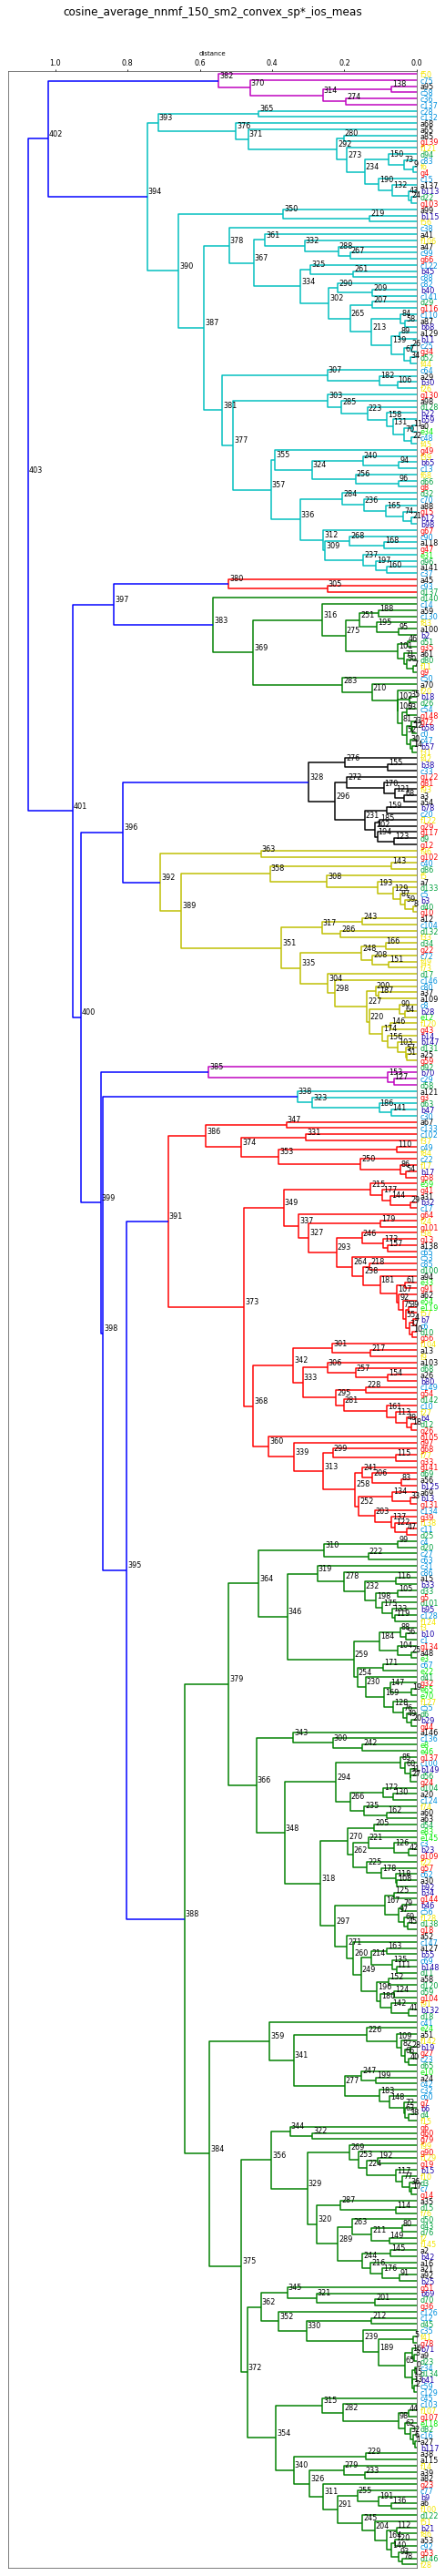

In [24]:
title = '_'.join((cluster_metric, linkage_scheme, method))

# create labels with abbreviations for animals. 
pseudo = dict(zip(animals, 'abcdefghij'))
pseudo['center'] = 'center'
pseudo_inv = {v: k for k, v in pseudo.items()}
new_labels = [pseudo[i.split('_')[0]] + i.split('_mode')[-1] for i in ts.label_objects]
# define color for each animal
animal_colors = [plt.cm.spectral(1.*animals.index(i.split('_')[0])/len(animals)) if i.split('_')[0] in animals else '0.5'
                 for i in ts.label_objects]

# plot hierachical clustering
fig = plt.figure(figsize=(7,len(new_labels)/10.))
ax = fig.add_axes([0.1,0.01,0.89,0.94])
d = dendrogram(link, orientation='left',  count_sort='descending', labels=new_labels)

# label coloring
for l_ind, l in enumerate(ax.yaxis.get_ticklabels()):
    mode = d['leaves'][l_ind]
    l.set_color(animal_colors[mode])
  
# annotate nodes with node id
node_order = list(np.sort(np.array(d['dcoord'])[:,1]))
for di, dd in zip(d['icoord'], d['dcoord']):
    y = 0.5 * sum(di[1:3])
    x = dd[1]
    ix = node_order.index(dd[1])
    ax.annotate("%d" % ix, (x, y), xytext=(1,1), textcoords='offset points', va='bottom', ha='left', size=8)    
   
# decorate axis
ax.set_xlabel('distance')
ax.yaxis.set_tick_params(labelsize=8)
ax.xaxis.set_tick_params(labelsize=8)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_title(title, y=1.02)

### Analysis of clustering in chemical space

#### Functions to create cluster visualization

In [41]:
def plot_location(ts, 
                  link, 
                  cluster, 
                  bg_dict, 
                  ax_dict, 
                  color_dict, 
                  face=True, 
                  base_thres=0.3, 
                  all_glom=False,
                  scalebar=True):
    ''' plot cluster location'''
    
    # plot bg
    for axname,ax in ax_dict.items():
        bg = bg_dict[axname].copy()
        if scalebar:
            pixel_size = 1.63/1344. *1000. #µm
            len_200 = int(round(200./pixel_size))   # 200 µm
            bg[900:920,(1200-len_200):1200]=1.


        ax.imshow(bg, interpolation='none', cmap=plt.cm.bone, extent=[0,84,64,0])
        ax.set_axis_off()
    
    if all_glom:
        for ix in range(ts.num_objects):
            measID = ts.label_objects[ix].split('_')[0]
            mode = ts.base.shaped2D()[ix]    
            ax_dict[measID].contourf(mode, [base_thres,1], colors=['0.5'], alpha=0.5)

    # plot location and timecouses of clusters
    for clust in cluster:    
        color = color_dict[clust]
        spec_collection = []
        for node in return_all_childs(link,clust+link.shape[0]+1):
            # get animal of cluster member
            measID = ts.label_objects[node].split('_')[0]
            # print pixel participation
            mode = ts.base.shaped2D()[node]    
            if face:
                ax_dict[measID].contourf(mode, [base_thres,1], colors=[color], alpha=0.5)
            else:
                ax_dict[measID].contour(mode, [base_thres], colors=[color], alpha=1, linewidths=[2])
                
                

#### Chemical distance to MOR18-2 cluster

calculate mean response of MOR18-2 cluster and it's distance to all other response spectra 

In [28]:
mor182_cluster_id = 98 

protoype_idx = return_all_childs(link, mor182_cluster_id + link.shape[0] + 1)
prototype = np.mean(ts._series[:,protoype_idx],1)
cor = squareform(pdist(np.hstack([prototype[:,np.newaxis], ts._series]).T, cluster_metric))[0,1:]

In [29]:
# automatic selection of cluster
# currently overwritten by manual selection

cluster_parents, _ = leaders(link, fcluster(link, 1.15))
#cluster_parents = cluster_parents - len(d['leaves'])
#cluster = list(cluster[cluster>0])
cluster_parents.shape

thres = 0.5
cluster = []
for parent_node in cluster_parents:
    cluster_idx = return_all_childs(link, parent_node)
    cluster_spec = np.mean(ts._series[:,cluster_idx],1)
    dist2mor182 =  pdist(np.vstack([prototype, cluster_spec]), cluster_metric)[0]
    if dist2mor182 < thres:
        cluster.append(parent_node - link.shape[0] - 1)

### Chemotopic Clustering

In [38]:
fig_dim = (7.48, 4.5)


In [39]:
def plot_hierachical_clusters(fig, gs_meta, cluster, labels=['a','b']):
    #manual selection of cluster
    num_cluster = len(cluster)

    num_animals = len(animals)
    num_stim = len(ts.label_stimuli)
    clust_colors = {clust: plt.cm.gist_rainbow_r(1.*cluster.index(clust)/num_cluster) for clust in cluster}

    gs_top = matplotlib.gridspec.GridSpecFromSubplotSpec(2, 2, gs_meta[0], hspace=0.01, height_ratios=[5,1], 
                                                         wspace=0.05, width_ratios=[16.5,0.3])

    # plot dendrogarm
    ax = fig.add_subplot(gs_top[0,0])
    top = gs_meta[0].get_position(fig).corners()[1,1]
    d = dendrogram(link, link_color_func = color_clusters(cluster, clust_colors), count_sort='descending', ax=ax)
    ax.set_xticks([])
    ax.set_ylabel('$\hat{d}_{cos}$', labelpad=-1)
    ax.set_yticks([0,0.5,1])
    ax.text(-200,1.1,'({})'.format(labels[0]), fontweight='bold', fontsize=global_fs, ha='left', va='center')
    #ax.set_ylim([0,0.2])


    print(np.max(((cor[d['leaves']]).reshape((1,-1)))))
    # plot MOR18-2 correlation
    ax = fig.add_subplot(gs_top[1,0])
    im = ax.imshow(((cor[d['leaves']]).reshape((1,-1))), cmap = plt.cm.RdYlGn_r, interpolation='none', 
                   aspect='auto', vmin=0, vmax=1.8)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel('glomeruli', labelpad=2)
    # colorbar
    axbar = fig.add_subplot(gs_top[:,1])
    cbar = plt.colorbar(im, cax=axbar)
    cbar.set_ticks([0,1])
    cbar.set_ticklabels([1,0])
    cbar.set_label('$cos_{MOR18-2}$', labelpad=-2)

    # plot locations
    gs = matplotlib.gridspec.GridSpecFromSubplotSpec(1, num_animals, gs_meta[1,:], wspace=0.02)
    top = gs_meta[1].get_position(fig).corners()[1,1]
    axbase = {animal: fig.add_subplot(gs[0,ix]) for ix, animal in enumerate(animals)}
    plot_location(ts, link, cluster, bg_dict, axbase, clust_colors, base_thres=0.5, all_glom=True)
    axbase[animals[0]].text(-27.5, 1.1, '({})'.format(labels[1]), fontweight='bold', fontsize=global_fs, ha='left', va='center')

    #savepath= os.path.join('Figures', 'chemotopy.png')
    #fig.savefig(savepath, bbox_inches='tight', dpi=600)

1.79678206221
1.79678206221


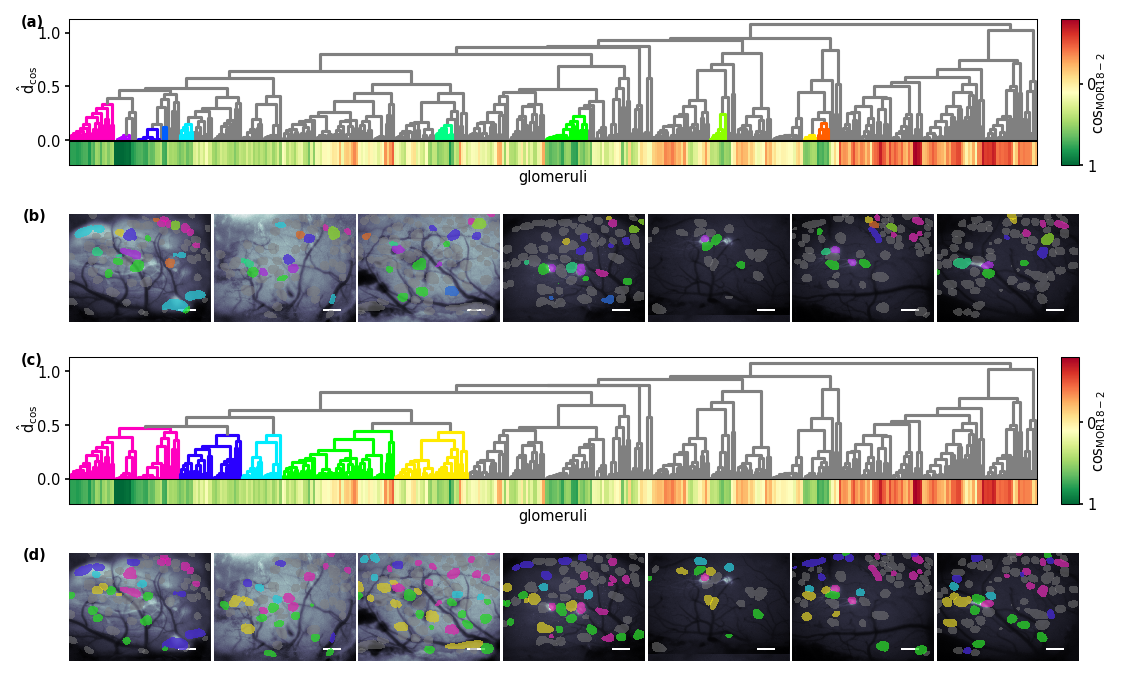

In [42]:
fig = plt.figure(figsize=fig_dim)
gs = matplotlib.gridspec.GridSpec(4, 1, bottom=0.01, top = 0.99, left = 0.05, right=0.95, 
                                       height_ratios=[1, 0.75, 1, 0.75], hspace=0.1)

gs_meta = matplotlib.gridspec.GridSpecFromSubplotSpec(2,1,gs[:2])
cluster = [340, 98, 189, 212, 244, 232, 293, 308, 101, 251]
plot_hierachical_clusters(fig, gs_meta, cluster)

gs_meta = matplotlib.gridspec.GridSpecFromSubplotSpec(2,1,gs[2:])
#cluster = [379, 384]
#cluster = [340, 315, 362, 356, 359, 366, 364]
cluster = [372, 356, 359, 366, 364]
plot_hierachical_clusters(fig, gs_meta, cluster, labels=['c','d'])


In [43]:
fig.savefig('results/chemotopic_clustering.png', dpi=600)

#### Spatial plot of all modes with functional distance to prototype

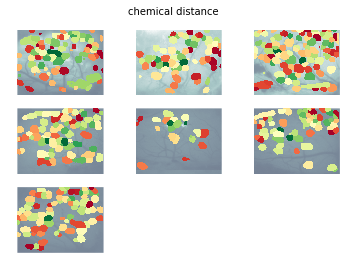

In [25]:
cluster_id = 98

fig = plt.figure()
gs = matplotlib.gridspec.GridSpec(3,int(np.ceil(num_animals/3.)))
axbase = [fig.add_subplot(gs[i]) for i in range(num_animals)]


for measID, ax in zip(animals, axbase):
    bg = bg_dict[measID]
    ax.imshow(bg, interpolation='none', cmap=plt.cm.bone, extent=[0,84,64,0], vmin=-1, vmax=1)
    ax.set_axis_off() 

what = ts
for obj_id in range(what.num_objects):
    measID = what.label_objects[obj_id].split('_')[0]
    pos = animals.index(measID)
    base = what.base.shaped2D()[obj_id]
    basecolor = plt.cm.RdYlGn_r(cor[obj_id]/1.5) #if cor[obj_id]<1 else '0.7'
    axbase[pos].contourf(base, [0.3,1], colors=[basecolor]) 
    
fig.suptitle('chemical distance')    
plt.show()

#### Distribution of chemical distances for spatial neigbours vs. non-neigbours

Neigbours are calculated as overlapping modes after extending the custermodes with dilation 

 distance neighbours: 0.70, nonneighbours: 0.88, p_values -> MWU: 0.00, KS: 0.00, T: 0.01


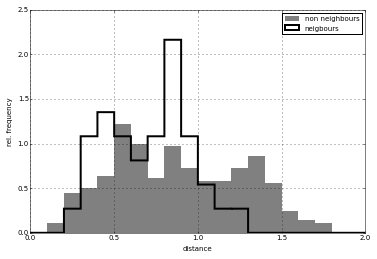

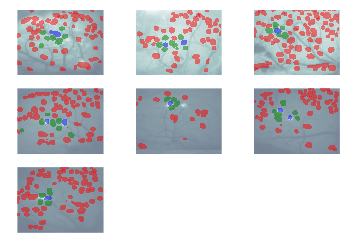

In [26]:
plt.figure()

for dilation in [6]: # range(1, 35, 1):

    thres = 0.6
    metric='cosine'
    show = True
    
    # get cluster member
    member_idx = return_all_childs(link,cluster_id+link.shape[0]+1)
    member_mask = np.zeros(ts.num_objects).astype('bool')
    member_mask[member_idx] = True
    
    
    # calculate which modes overlap with cluster modes
    neighbour_modes = np.zeros(ts.num_objects).astype('bool')
    for animal in animals:
        animal_mask = np.array([animal in mode for mode in ts.label_objects])
        neighbour_pixel = np.logical_or(ts.base.shaped2D()[animal_mask*member_mask]>thres,0).squeeze()
        if dilation:
            neighbour_pixel = scipy.ndimage.morphology.binary_dilation(neighbour_pixel, iterations=dilation)
        neighbour_modes[animal_mask] = np.max(ts.base._series[animal_mask][:,neighbour_pixel.flatten()],1)>thres
    neighbour_modes[member_mask]=False    
    
    # calculate mode distances
    prototype = np.mean(ts._series[:,member_idx],1)
    dist = squareform(pdist(np.hstack([prototype[:,np.newaxis], ts._series]).T, metric))[0,1:]
    dist_neighbours = dist[neighbour_modes]
    dist_nonneighbours = dist[~(neighbour_modes+member_mask)]
    
    if show:
        # plot distance distribution
        ax = plt.subplot(111)
        ax.hist(dist_nonneighbours, np.linspace(0,2,21), color=['0.5'], normed=True, lw=0, rwidth=1, label='non neighbours')
        ax.hist(dist_neighbours, np.linspace(0,2,21), color='k', normed=True, histtype='step', lw=2, rwidth=1, label= 'neigbours')
        ax.set_xlabel('distance')
        ax.set_ylabel('rel. frequency')
        ax.grid()
        plt.legend()
        
        # plot neighbour modes
        fig = plt.figure()
        gs = matplotlib.gridspec.GridSpec(3,int(np.ceil(num_animals/3.)))
        axbase = [fig.add_subplot(gs[i]) for i in range(num_animals)]
        
        
        for measID, ax in zip(animals, axbase):
            bg = bg_dict[measID]
            ax.imshow(bg, interpolation='none', cmap=plt.cm.bone, extent=[0,84,64,0], vmin=-1, vmax=1)
            ax.set_axis_off() 
        
        for obj_id in range(what.num_objects):
            measID = what.label_objects[obj_id].split('_')[0]
            pos = animals.index(measID)
            base = what.base.shaped2D()[obj_id]
            basecolor ='g' if neighbour_modes[obj_id] else ('b' if member_mask[obj_id] else 'r')
            axbase[pos].contourf(base, [thres,1], colors=[basecolor], alpha=0.5) # if cor[obj_id]<1 else (1.,0.1,0.1)], alpha=0.9)
        
        
    # calculate significane of distribution difference
    _, p_mwu = scipy.stats.mannwhitneyu(dist_neighbours, dist_nonneighbours)
    _, p_ks = scipy.stats.ks_2samp(dist_neighbours, dist_nonneighbours)
    _, p_tt = scipy.stats.ttest_ind(dist_neighbours, dist_nonneighbours)
    print ' distance neighbours: %.2f, nonneighbours: %.2f, p_values -> MWU: %.2f, KS: %.2f, T: %.2f'%(np.mean(dist_neighbours),np.mean(dist_nonneighbours), p_mwu, p_ks, p_tt)